# Attention is All You Need
源自：
> http://nlp.seas.harvard.edu/2018/04/03/attention.html#encoder

> https://zhuanlan.zhihu.com/p/48731949

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, time, copy
from torch.autograd import  Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context( context='talk' )
%matplotlib inline

The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed- forward network.<br>
![Transformer] (http://nlp.seas.harvard.edu/images/the-annotated-transformer_14_0.png "Transformer")

In [ ]:
class EncoderDecoder( nn.Module ):
    '''
    A standard Encoder-Decoder architecture. Base for this          and many other models.
    '''
    def __init__( self, encoder, decoder, src_embed, tgt_embed, generator ):
        super( EncoderDecoder, self ).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward( self, src, tgt, src_mask, tgt_mask ):
        '''Take in and process masked src and target sequences.'''
        return self.decode( self.encode( src, src_mask ), src_mask, tgt, tgt_mask )

    def encode( self, src, src_mask ):
        return self.encoder( self.src_embed( src ), src_mask )
    
    def decode( self, memory, src_mask, tgt, tgt_mask ):
        return self.decoder( self.tgt_embed( tgt ), memory, src_mask, tgt_mask )


In [ ]:
class Generator( nn.Module ):
    '''Define standard linear + softmax generation step.'''
    def __init__( self, d_model, vocab ):
        super( Generator, self ).__init__()
        self.proj = nn.Linear( d_model, vocab )

    def forward( self, x ):
        return F.log_softmax( self.proj( x ), dim=1 )

# Encoder
The encoder is composed of a stack of $N=6$ identical layers.

In [ ]:
def clones( module, N ):
    '''Produce N identical layers.'''
    return nn.ModuleList( [ copy.deepcopy( module ) for _ in range( N ) ] )

In [ ]:
class Encoder( nn.Module ):
    "Core encoder is a stack of N layers"
    def __init__( self, layer, N ):
        super( Encoder, self ).__init__()
        self.layers = clones( layer, N )
        self.norm = LayerNorm( layer.size )

    def forward( self, x, mask ):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer( x, mask )
        return self.norm( x )

We employ a residual connection (cite) around each of the two sub-layers, followed by layer normalization (cite).

EncoderLayer: 每层都有两个子层组成。第一个子层实现了“多头”的 Self-attention，第二个子层则是一个简单的Position-wise的全连接前馈网络。

In [ ]:
class EncoderLayer( nn.Module ):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__( self, size, self_attn, feed_forward, dropout ):
        super( EncoderLayer, self ).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones( SublayerConnection( size, dropout=dropout ), 2 )
        self.size = size

    def forward( self, x, mask ):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0]( x, lambda x: self.self_attn( x, x, x, mask ) )
        return self.sublayer[1]( x, self.feed_forward )

In [ ]:
class LayerNorm( nn.Module ):
    "Construct a layernorm module (See citation for details)."
    def __init__( self, features, eps=1e-6 ):
        super( LayerNorm, self ).__init__()
        self.a_2 = nn.Parameter( torch.ones( features ) )
        self.b_2 = nn.Parameter( torch.zeros( features ) )
        self.eps = eps

    def forward( self, x ):
        mean = x.mean( -1, keepdim=True )
        std = x.std( -1, keepdim=True )
        return self.a_2 * ( x - mean ) / ( std * self.eps ) + self.b_2

In [ ]:
class SublayerConnection( nn.Module ):
    '''
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    '''
    def __init__( self, size, dropout ):
        super( SublayerConnection, self ).__init__()
        self.norm = LayerNorm( size )
        self.dropout = nn.Dropout( dropout )

    def forward( self, x, sublayer ):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout( sublayer( self.norm( x ) ) )

# Decoder

Decoder也是由N=6个相同层组成。

In [ ]:
class Decoder( nn.Module ):
    "Generic N layer decoder with masking."
    def __init__( self, layer, N ):
        super( Decoder, self ).__init__()
        self.layers = clones( layer, N )
        self.norm = LayerNorm( layer.size )

    def forward( self, x, memory, src_mask, tgt_mask ):
        for layer in self.layers:
            x = layer( x, memory, src_mask, tgt_mask )
        return self.norm( x ) 

(DecoderLayer)

In [ ]:
class DecoderLayer( nn.Module ):
    "Decoder is made of self_attn, src_attn, and feed forward (defined below)"
    def __init__( self, size, self_attn, src_attn, feed_forward, dropout ):
        super( DecoderLayer, self ).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones( SublayerConnection( size, dropout ), 3 )

    def forward( self, x, memory, src_mask, tgt_mask ):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0]( x, lambda x: self.self_attn( x, x, x, tgt_mask ) )
        x = self.sublayer[1]( x, lambda x: self.src_attn( x, x, x, src_mask ) )
        return self.sublayer[2]( x, self.feed_forward )

我们还修改了解码器中的Self-attetion子层以防止当前位置attend到后续位置。这种Masked的Attention是考虑到输出Embedding会偏移一个位置，确保了生成位置i的预测时，仅依赖于i的位置处已知输出，相当于把后面不该看的信心屏蔽掉

In [ ]:
def subsequent_mask( size ):
    "Mask out subsequent positions."
    attn_shape = ( 1, size, size )
    subsequent_mask = np.triu( np.ones( attn_shape ), k=1 ).astype( 'uint8' )
    return torch.from_numpy( subsequent_mask ) == 0

plt.figure( figsize=( 5, 5 ) )
plt.imshow( subsequent_mask( 19 )[0] )

## Attention
An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.
We call our particular attention “Scaled Dot-Product Attention”. The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$. We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.
<img src="https://pic2.zhimg.com/80/v2-c5dcddf20d8b2d7ce0130fac2071317d_720w.jpg" />


In [ ]:
def attention( query, key, value, mask=None, dropout=None ):
    "Compute 'Scaled Dot Product Attention"
    d_k = query.size( -1 )
    scores = torch.matmul( query, key.transpose( -2, -1 )) \
             / math.sqrt( d_k )
    if mask is not None:
        scores = scores.masked_fill( mask == 0.0, -1e9 )
    p_attn = F.softmax( scores, dim=-1 )
    if dropout is not None:
        p_attn = dropout( p_attn )
    return torch.matmul( p_attn, value ), p_attn

MultiHead:<br>

<img  src="http://nlp.seas.harvard.edu/images/the-annotated-transformer_38_0.png" width=25% height=25% />

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.

$\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ...,
\mathrm{head_h})W^O    \\
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)
$

Where the projections are parameter matrices $W^Q_i \in
\mathbb{R}^{d_{\text{model}} \times d_k}$, WKi∈Rdmodel×dk, WVi∈Rdmodel×dv and WO∈Rhdv×dmodel. In this work we employ h=8 parallel attention layers, or heads. For each of these we use dk=dv=dmodel/h=64. Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimensionality.

“多头”机制能让模型考虑到不同位置的Attention，另外“多头”Attention可以在不同的子空间表示不一样的关联关系，使用单个Head的Attention一般达不到这种效果。

In [ ]:
class MultiHeaderAttention( nn.Module ):
    def __init__( self, h, d_model, dropout=0.1 ):
        "Take in model size and number of heads."
        super( MultiHeaderAttention, self ).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones( nn.Linear( d_model, d_model ), 4 )
        self.attn = None
        self.dropout = nn.Dropout( p=dropout )

    def forward( self, query, key, value, mask=None ):
        "Implements Figure 2"
        if mask is not None:
            mask = mask.unsqueeze( 1 )
        nbatches = query.size( 0 )
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [ l(x).view( nbatches, -1, self.h, self.d_k ).transpose( 1, 2 )
              for l, x in zip( self.linears, ( query, key, value )) ]
        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention( query, key, value, mask=mask, dropout=self.dropout )
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose( 1, 2 ).contingous() \
            .view( nbatches, -1, self.h * self.d_k )
        return self.linears[-1]( x )

> attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.

In [ ]:
class PositionwiseFeedForward( nn.Module ):
    "Implements FFN equation."
    def __init__( self, d_model, d_ff, dropout=0.1 ):
        super( PositionwiseFeedForward, self ).__init__()
        self.w_1 = nn.Linear( d_model, d_ff )
        self.w_2 = nn.Linear( d_ff, d_model )
        self.dropout = nn.Dropout( dropout )

    def forward( self, x ):
        return seld.w_2( self.dropout( F.relu( self.w_1( x ) )) )

# Emedding 和 softmax

<img src="https://pic2.zhimg.com/80/v2-ca9c861576e2aac1ee7211d4e0bc6281_720w.jpg" />

In [ ]:
class Embeddings( nn.Module ):
    def __init__( self, d_model, vocab ):
        super( Embeddings, self ).__init__()
        self.lut = nn.Embedding( vocab, d_model )
        self.d_model = d_model

    def forward( self, x ):
        return self.lut( x ) * math.sqrt( self.d_model )

# 位置编码

In [ ]:
class PositionalEncoding( nn.Module ):
    "Implement the PE function."
    def __init__( self, d_model, dropout, max_len=5000 ):
        super( PositionalEncoding, self ).__init__()
        self.dropout = nn.Dropout( p=dropout )

        # Compute the positional encodings once in log space.
        pe = torch.zeros( max_len, d_model )
        position = torch.arange( 0, max_len ).unsqueeze( 1 ).float()
        div_term = torch.exp( torch.arange( 0., d_model, 2) * -(math.log(10000.0) / d_model ) )
        pe[ :, 0::2 ] = torch.sin( position * div_term )
        pe[ :, 1::2 ] = torch.cos( position * div_term )
        pe = pe.unsqueeze( 0 )
        self.register_buffer( 'pe', pe )

    def forward( self, x ):
        x = x + Variable( self.pe[ :, :x.size(1) ], requires_grad=False )
        return self.dropout( x )

In [ ]:
plt.figure( figsize=( 15, 5) )
pe = PositionalEncoding( 20, 0 )
y = pe.forward( Variable( torch.zeros( 1, 100, 20 ) ))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])


Here we define a function that takes in hyperparameters and produces a full model.

In [ ]:
def make_model( src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1 ):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeaderAttention( h, d_model )
    ff = PositionwiseFeedForward( d_model, d_ff, dropout )
    position = PositionalEncoding( d_model, dropout )

    model = EncoderDecoder( 
        Encoder( EncoderLayer( d_model, c(attn), c(ff), dropout ), N ),
        Decoder( DecoderLayer( d_model, c(attn), c(attn), c(ff), dropout ), N ),
        nn.Sequential( Embeddings( d_model, src_vocab ), c(position) ),
        nn.Sequential( Embeddings( d_model, tgt_vocab ), c(position) ),
        Generator( d_model, tgt_vocab )
    )

    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform( p )
    return model


In [ ]:
tmp_model = make_model(10, 10, 2)
print( tmp_model )


## Batches and Masking

In [ ]:
class Batch( ):
    "Object for holding a batch of data with mask during training."
    def __init__( self, src, trg=None, pad=0 ):
        self.src = src
        self.src_mask = ( src != pad ).unsqueeze( -2 )
        if trg is not None:
            self.trg = trg[ :, :-1 ]
            self.trg_y = trg[ :, 1: ]
            self.trg_mask = self.make_std_mask( self.trg, pad  )
            self.ntokens = ( self.trg_y != pad ).data.sum()

     @staticmethod       
    def make_std_mask( tgt, pad ):
        "Create a mask to hide padding and future words."
        tgt_mask = ( tgt != pad ).unsqueeze( -2 )
        tgt_mask = tgt_mask & Variable( 
            subsequent_mask( tgt.size( -1 ).type_as( tgt_mask.data ))
        )
        return tgt_mask



## Training LOoop


In [ ]:
def run_epoch( data_iter, model, loss_compute ):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0

    for i, batch in enumerate( data_iter ):
        out = model.forward( batch.src, batch.trg, \
                             batch.src_mask, batch.trg_mask )
        loss = loss_compute( out, batch.trg_y, batch.ntokens )
        total_loss += loss
        total_tokens += batch.ntokens

        if i % 50 == 1:
            elapsed = time.time() - start
            print( 'Epoch Step: %4d Loss:%5.4f Tokens per sec  %4.2f' % ( i, loss / batch.ntokens, tokens / elapsed ))
            start = time.time()
            tokens = 0
    
    return total_token / total_tokens

and Batching

In [ ]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn( new, count, sofar ):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max( max_src_in_batch, len( new.src ) )
    max_tgt_in_batch = max( max_tgt_in_batch, len( new.trg ) + 2 )
    src_elemnets = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch

    return max( src_elemnets, tgt_elements )



We used the Adam optimizer (cite) with β1=0.9, β2=0.98 and ϵ=10−9.

>> Note: This part is very important. Need to train with this setup of the model.

In [ ]:
class NoamOpt():
    "Optim wrapper that implements rate."
    def __init__( self, model_size, factor, warmup, optimizer ):
        self.optimizer = optimizer
        self.step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step( self ):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p[ 'lr' ] = rate
        self._rate = rate
        self.optimizer.step()

    def rate( self, step=None ):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
                ( self.model_size ** ( -0.5 ) * 
                   min( step ** ( -0.5 ), step * self.warmup ** ( -1.5)))


def get_std_opt( model ):
    return NoamOpt( model.src_embed[0].d_model, 2, 4000,
                  torch.optim.Adam( model.parameters(), lr=0, betas=( 0.9, 0.98 ), eps=1e-9 ))

In [ ]:
# Three settings of the lrate hyperparameters.
opts = [ NoamOpt( 512, 1, 4000, None ),
         NoamOpt( 1024, 1, 8000, None ),
         NoamOpt( 256, 1, 4000, None )]
plt.plot( np.arange( 1, 20000 ), [ [ opt.rate( i ) for opt in opts ] for i in range( 1, 20000 ) ])
plt.legend( [ '512:4000', '1024:8000', '256:4000'])


## Label Smoothing
  mmnnrnrenrennren令人迷惑，但确实能改善accuracy and BLEU 成绩.

In [27]:
class LabelSmoothing( nn.Module ):
    "Implement label smoothing."
    def __init__( self, size, padding_idx, smoothing=0.0 ):
        super( LabelSmoothing, self ).__init__()
        self.criterion = nn.KLDivLoss( size_average=False )
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward( self, x, target ):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_( self.smoothing / ( self.size - 2 ) )
        true_dist.scatter_( 1, target.data.unsqueeze(1), self.confidence )
        true_dist[ :, self.padding_idx ] = 0
        mask = torch.nonzero( target.data == self.padding_idx )
        if mask.dim() > 0:
            true_dist.index_fill( 0, mask.squeeze(), 0.0 )
        self.true_dist = true_dist
        return self.criterion( x, Variable( true_dist, requires_grad=False ) )

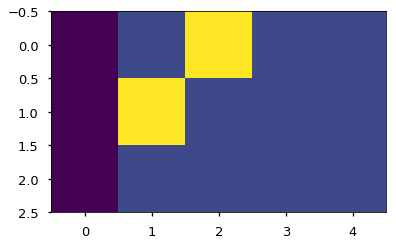

In [29]:
# Example of label smoothing.
crit = LabelSmoothing( 5, 0, 0.4 )
predict = torch.FloatTensor( [[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]] )
v = crit( Variable( predict.log() ), Variable( torch.LongTensor( [ 2, 1, 0 ] ) ) )
plt.imshow( crit.true_dist )

当model对选择给出非常有信心时， sjissjsjisjiisj实际上会开始惩罚model（防止过拟？)

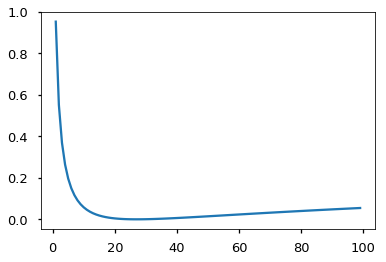

In [33]:
crit = LabelSmoothing( 5, 0, 0.1 )
def loss( x ):
    d = x + 3 * 1
    predict = torch.FloatTensor( [[ 0, x/d, 1/d, 1/d, 1/d ]] )
    return crit( Variable( predict.log() ), Variable( torch.LongTensor( [1] ) ) ).item()

plt.plot( np.arange(1, 100), [loss(x) for x in range(1, 100)] )